# Lockman SWIRE master catalogue
## Preparation of Red Cluster Sequence Lensing Survey (RCSLenS) data

This catalogue comes from `dmu0_RCSLenS`.

In the catalogue, we keep:

- The `id` as unique object identifier;
- The position;
- The g, r, i, z, y auto magnitudes.



In [2]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
a03d5b3 (Wed Jul 5 12:19:29 2017 +0100) [with local modifications]


In [3]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "rcs_ra"
DEC_COL = "rcs_dec"

## I - Column selection

In [5]:
imported_columns = OrderedDict({
        "id": "rcs_id",
        "ALPHA_J2000": "rcs_ra",
        "DELTA_J2000": "rcs_dec",
        "CLASS_STAR": "rcs_stellarity",
        "MAG_g": "m_rcs_g",
        "MAGERR_g": "merr_rcs_g",
        "MAG_r": "m_rcs_r",
        "MAGERR_r": "merr_rcs_r",        
        "MAG_i": "m_rcs_i",
        "MAGERR_i": "merr_rcs_i",
        "MAG_z": "m_rcs_z",
        "MAGERR_z": "merr_rcs_z",
        "MAG_y": "m_rcs_y",
        "MAGERR_y": "merr_rcs_y"    
    })


catalogue = Table.read("../../dmu0/dmu0_RCSLenS/data/RCSLenS_Lockman-SWIRE.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [6]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:39: RuntimeWarning: overflow encountered in power
  fluxes = 10 ** ((8.9 - magnitudes)/2.5)
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:43: RuntimeWarning: invalid value encountered in multiply
  errors = np.log(10)/2.5 * fluxes * errors_on_magnitudes


In [7]:
catalogue[:10].show_in_notebook()

idx,rcs_id,rcs_ra,rcs_dec,rcs_stellarity,m_rcs_g,merr_rcs_g,m_rcs_r,merr_rcs_r,m_rcs_i,merr_rcs_i,m_rcs_z,merr_rcs_z,m_rcs_y,merr_rcs_y,f_rcs_g,ferr_rcs_g,flag_rcs_g,f_rcs_r,ferr_rcs_r,flag_rcs_r,f_rcs_i,ferr_rcs_i,flag_rcs_i,f_rcs_z,ferr_rcs_z,flag_rcs_z,f_rcs_y,ferr_rcs_y,flag_rcs_y
0,CDE1040B3_008051,162.7980696,57.8462577,0.35,25.1618,0.0697623,23.9381,0.0334968,22.6801,0.0217731,22.3473,0.0413988,-99.0,-99.0,0.312809,0.0200991,False,0.965516,0.0297878,False,3.07581,0.0616816,False,4.17907,0.159347,False,inf,-inf,False
1,CDE1040B3_008092,162.8203016,57.8467287,0.69,24.8891,0.0495108,24.548,0.0452512,24.0667,0.0545663,23.9566,0.132427,-99.0,-99.0,0.402124,0.0183373,False,0.550554,0.0229459,False,0.85767,0.0431043,False,0.949205,0.115774,False,inf,-inf,False
2,CDE1040B3_008109,162.8056847,57.8469354,0.02,24.0753,0.0394333,24.0281,0.0442413,23.7282,0.0626359,99.0,99.0,-99.0,-99.0,0.850902,0.0309043,False,0.88871,0.0362129,False,1.17144,0.06758,False,9.12009e-31,8.31591e-29,False,inf,-inf,False
3,CDE1040B3_008126,162.7844289,57.8470931,0.61,24.8095,0.0615288,24.7486,0.0694756,24.689,0.123541,99.0,99.0,-99.0,-99.0,0.432713,0.0245219,False,0.457678,0.0292865,False,0.483504,0.0550157,False,9.12009e-31,8.31591e-29,False,inf,-inf,False
4,CDE1040B3_008157,162.8025215,57.8472832,0.98,99.0,99.0,22.3103,0.00966064,21.9649,0.0112024,21.7301,0.0225916,-99.0,-99.0,9.12009e-31,8.31591e-29,False,4.32394,0.0384734,False,5.94347,0.0613235,False,7.37835,0.153526,False,inf,-inf,False
5,CDE1040B3_008160,162.7540796,57.8472555,0.37,25.4333,0.0990134,24.7743,0.0724826,99.0,99.0,99.0,99.0,-99.0,-99.0,0.243601,0.0222152,False,0.446972,0.0298394,False,9.12009e-31,8.31591e-29,False,9.12009e-31,8.31591e-29,False,inf,-inf,False
6,CDE1040B3_008169,162.7612297,57.8473226,0.14,24.471,0.0586908,23.695,0.0393606,23.7305,0.0741098,23.0113,0.107709,-99.0,-99.0,0.591017,0.0319481,False,1.20781,0.0437862,False,1.16896,0.0797905,False,2.26715,0.22491,False,inf,-inf,False
7,CDE1040B3_008193,162.6800562,57.8472861,0.58,24.388,0.0804324,24.1185,0.0786203,24.3138,0.175572,99.0,99.0,-99.0,-99.0,0.637969,0.0472614,False,0.817711,0.0592121,False,0.683092,0.110461,False,9.12009e-31,8.31591e-29,False,inf,-inf,False
8,CDE1040B3_008200,162.7555299,57.8475131,0.53,24.8821,0.0969365,24.338,0.0775129,99.0,99.0,23.0418,0.129057,-99.0,-99.0,0.404725,0.0361346,False,0.668036,0.0476925,False,9.12009e-31,8.31591e-29,False,2.20435,0.262022,False,inf,-inf,False
9,CDE1040B3_008206,162.6779324,57.8474348,0.59,24.157,0.0394904,24.015,0.0415514,23.6005,0.0534222,23.122,0.0946982,-99.0,-99.0,0.789224,0.0287056,False,0.899498,0.034424,False,1.31765,0.0648331,False,2.04739,0.178574,False,inf,-inf,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:
SORT_COLS = []
FLAG_NAME = 'rcs_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 221225 sources.
The cleaned catalogue has 216618 sources (4607 removed).
The cleaned catalogue has 4608 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Lockman-SWIRE.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

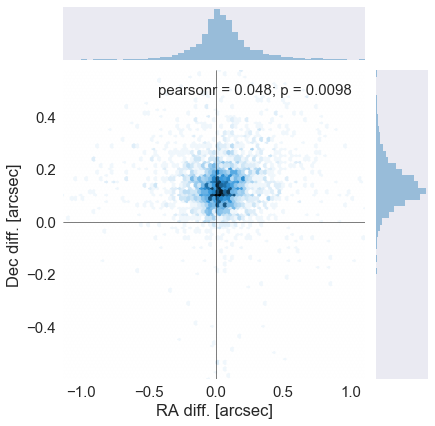

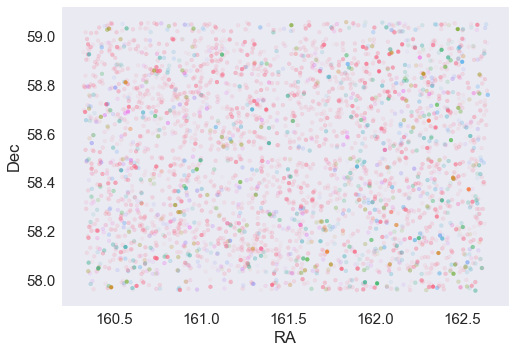

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.03738936952686345 arcsec
Dec correction: -0.12916321127534047 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

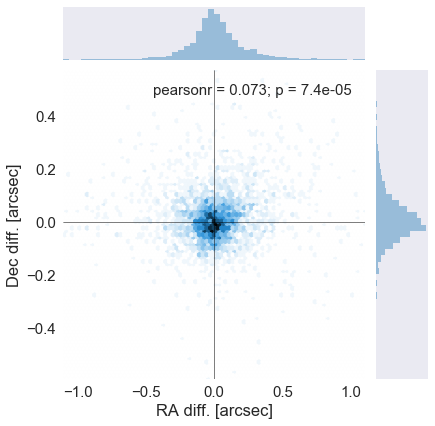

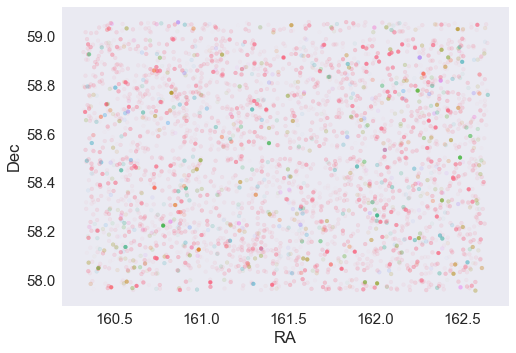

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "rcs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

3229 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/RCSLenS.fits".format(OUT_DIR), overwrite=True)